# Struggle Analysis Notebook

This notebook demonstrate calculation of customer struggle score, and basic analysis of results. The first step is calculating the score using an SQL that counts how many errors, retries etc. happened per session.

## Login to Database

In [1]:
#Read Redshift credentials
import boto3
import base64
from botocore.exceptions import ClientError
import ast

def get_secret():

    secret_name = "GBRedshiftSecret"
    region_name = "us-east-2"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    # In this sample we only handle the specific exceptions for the 'GetSecretValue' API.
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    # We rethrow the exception by default.

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException':
            # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException':
            # An error occurred on the server side.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException':
            # You provided an invalid value for a parameter.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException':
            # You provided a parameter value that is not valid for the current state of the resource.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException':
            # We can't find the resource that you asked for.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
    else:
          # Decrypts secret using the associated KMS CMK.
        # Depending on whether the secret is a string or binary, one of these fields will be populated.
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
            return(secret)
        else:
            decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            return(decode_binary_secret)

secret = get_secret()
USER = ast.literal_eval(secret)['username']
PASSWORD = ast.literal_eval(secret)['password']
HOST = ast.literal_eval(secret)['host']

In [2]:
import psycopg2
import time
import datetime
import logging
import os
import sys

print('Connecting to Redshift')
try:
    con = psycopg2.connect(
        dbname='prod',
        user=USER,
        password=PASSWORD,
        port=5439,
        host=HOST)
except Exception as ERROR:
    print("Connection Issue: " + ERROR)
    sys.exit(1)
print("Connection Successful!")

Connecting to Redshift
Connection Successful!


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Add Data to Score Table

In [ ]:
now = datetime.datetime.now()
week = int(now.strftime('%U'))
#logging.basicConfig(filename='/home/ec2-user/src/updatecsscore.log', level=logging.DEBUG, format='%(asctime)s %(levelname)s %(message)s')

sqlmsg1 = "--delete from cs_score; commit;"
sqlmsg2 = """
insert into cs_score
 -- Read one week of sessions
with ts as
  (select max(session_ts) - 14 * 24 * 3600000 as session_ts
  from page_loads_tf)

select z.session_uuid,
       z.session_ts,
       nvl(a.num_page_err, 0.0) as page_err,
       nvl(b.num_backforward, 0.0) as back_forth,
       nvl(c.total_page_loadtime, 0.0) as total_page_loadtime,
       nvl(d.numchanges,0.0) as num_changes,
       nvl(e.num_jserrors,0.0) as js_errors,
       nvl(f.total_ajax_responsetime,0.0) as ajax_resp,
       nvl(g.total_dwelltime,0.0) as dwell_time,
       nvl(h.num_ajaxerrors,0.0) as ajax_errors,
       (page_err + back_forth + c.total_page_loadtime + num_changes + js_errors + ajax_resp + dwell_time + ajax_errors) as CS_Score,
       i.city, i.country, i.os, i.resolution_family, i.uabrowser_group, i.uadevicetype, i.vendor,
       j.TAG
from
(select distinct session_uuid, session_ts
from page_loads_tf
where session_ts > (select * from ts)
) as z

------------------------- Number of page loads with error message. ---------------------------
left join
(
select session_uuid, 1.0 * count(*)/(select max(num_page_err) from
          (select session_uuid, count(*) as num_page_err
           from page_loads_tf
           where session_ts > (select * from ts) and page_title like '%rror%'
           group by session_uuid)) as num_page_err
from page_loads_tf
where session_ts > (select * from ts) and page_title like '%rror%'
group by session_uuid
) as a on z.session_uuid = a.session_uuid

--------------------- Number of back and forward --------------------------------------
left join
(
select session_uuid, 1.0 * count(*)/(select max(num_back_forward) from
              (select session_uuid, count(*) as num_back_forward
              from page_loads_tf
              where session_ts > (select * from ts) and navigation_type = 'TYPE_BACK_FORWARD'
              group by session_uuid)) as num_backforward
from page_loads_tf
where session_ts > (select * from ts) and navigation_type = 'TYPE_BACK_FORWARD'
group by session_uuid
) as b on z.session_uuid = b.session_uuid

----------------------- Total pages load time -------------------------------------------
left join
(
with  maxloadtime as (select max(total_page_load_time) as maxload 
      from
      (select session_uuid, sum(page_load_time) as total_page_load_time
       from page_loads_tf
       where session_ts > (select * from ts)
       group by session_uuid
       )
     )

select session_uuid, 1.0 * sum(page_load_time)/(select max(maxload) from maxloadtime) as total_page_loadtime
from page_loads_tf
where session_ts > (select * from ts)
group by session_uuid
) as c on z.session_uuid = c.session_uuid

--------------------- Number of action = changes ------------------------------------------
left join
(
select session_uuid, 1.0 * count(*)/(select max(num_changes) from
              (select session_uuid, count(*) as num_changes
              from useractions
              where session_ts > (select * from ts) and client_action = 'change'
              group by session_uuid)) as numchanges
from useractions
where session_ts > (select * from ts) and client_action = 'change'
group by session_uuid
) as d on z.session_uuid = d.session_uuid

----------------------- Number of Java Script errors ------------------------------------
left join
(
with maxjserr as (select session_uuid, count(*) as num_js_errors
                  from useractions
                  where session_ts > (select * from ts) and client_action = 'error'
                  group by session_uuid)
select session_uuid, 1.0 * count(*)/(select max(num_js_errors) from maxjserr) as num_jserrors
from useractions
where session_ts > (select * from ts) and client_action = 'error'
group by session_uuid
) as e on z.session_uuid = e.session_uuid

----------------------- Total time of ajaxRequest response ------------------------------
left join
(
select session_uuid, 1.0 * ln(sum(focus_duration))/(select max(ln(total_ajax_response_time)) from
            (select session_uuid, sum(focus_duration) as total_ajax_response_time
            from useractions
            where session_ts > (select * from ts) and client_action = 'ajaxRequest'
            group by session_uuid)) as total_ajax_responsetime
from useractions
where session_ts > (select * from ts) and client_action = 'ajaxRequest'
group by session_uuid
) as f on z.session_uuid = f.session_uuid

------------------------- Total dwell time ----------------------------------------------
left join
(
select session_uuid, 1.0 * ln(sum(focus_duration))/(select max(ln(total_dwell_time)) from
            (select session_uuid, sum(focus_duration) as total_dwell_time
            from useractions
            where session_ts > (select * from ts) and client_action = 'unload'
            group by session_uuid)) as total_dwelltime
from useractions
where session_ts > (select * from ts) and client_action = 'unload'
group by session_uuid
) as g on z.session_uuid = g.session_uuid

--------------------------- Total number of AJAX errors --------------------------------
left join
(
select session_uuid, 1.0 * count(*)/(select max(num_ajax_errors) from
          (select session_uuid, count(*) as num_ajax_errors
          from useractions
          where session_ts > (select * from ts) and client_action = 'ajaxRequest' and NOT (dom_value like '%statusCode=200%')
          group by session_uuid)) as num_ajaxerrors
from useractions
where session_ts > (select * from ts) and client_action = 'ajaxRequest' and NOT (dom_value like '%statusCode=200%')
group by session_uuid
) as h on z.session_uuid = h.session_uuid

left join
(
select session_uuid, max(city) as city, max(country) as country, max(os) as os, max(resolution_family) as resolution_family, max(uabrowser_group) as uabrowser_group, max(uadevicetype) as uadevicetype, max(vendor) as vendor
from page_loads_tf
where session_ts > (select * from ts)
group by session_uuid
) as i on z.session_uuid = i.session_uuid

left join
(
select session_uuid, max (case
                           -- Funnel 1 example
                           when dom_value like '%/activation/airtimeserviceplan%' and client_action = 'segmentChanged' then 1
                           when uri like '%/activation/serviceplan%' and client_action = 'segmentChanged' then 2
                           when uri like '%/activation/checkout%' and client_action = 'segmentChanged' then 3
                           when uri like '%/activation/instructions%' and client_action = 'segmentChanged' then 4
                           -- Funnel 2 example
                           when dom_element like '%lnk_tfhome_activate%' then 10
                           when dom_element like '%btn_continuetracfonephone%' then 11
                           when dom_element like '%btn_imeicontinue%' then 12
                           when dom_element like '%btn_changenumber%' then 13
                           when dom_element like '%btn_continuepurchase%' then 14
                           when dom_element like '%btn_plancardaddtocart%' then 15
                           when dom_element like '%btn_enrollinautorefill%' then 16
                           when dom_element like '%btn_placeyourorder%' then 17
                           when dom_element like '%btn_continuesetupphone%' then 18
                           when action_visual_name like '%purchasesummary%' then 19
                           else 0 end) as TAG
from useractions
where session_ts > (select * from ts)
group by session_uuid
) as j on z.session_uuid = j.session_uuid;
commit;
"""

cur = con.cursor()
cur.execute(sqlmsg1)
con.commit()
cur.execute(sqlmsg2)
con.commit()
print("Successfully update cs_score table")
con.close()

# Basic Statistics, Load Data

In [3]:
import pandas as pd
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

url_string = f"dbname='prod' port=5439 user='{USER}' password='{PASSWORD}' host='{HOST}'"
con = psycopg2.connect(url_string)
print(time.ctime(), "Redshift connection Successful!")
cur = con.cursor()
#SQL message for calculating CS score for sessions in the last 14 days.
sqlmsg = "with ts as \
          (select max(session_ts) - 14 * 24 * 3600000 as session_ts \
          from page_loads_tf) \
          select * \
          from cs_score \
          limit 1000; \
          --where session_ts > (select session_ts from ts);"
cur.execute(sqlmsg)
data = pd.DataFrame(cur.fetchall(), columns=['session_uuid', 'session_ts', 'page_err', 'back_forth', 'total_page_loadtime', 'num_changes', 'js_errors',
'ajax_resp', 'dwell_time', 'ajax_errors', 'CS_Score', 'city', 'country', 'os', 'resolution_family', 'uabrowser_group', 'uadevicetype', 'vendor',
'TAG'])
data.fillna(0, inplace=True)
#We can sample only partial data.
#data = data.sample(10000).reset_index()
#TAG is the lable column (a success checkout is 4). It indicates the step reached in the funnel.
data.head()

Tue Aug 13 09:03:48 2019 Redshift connection Successful!


,session_uuid,session_ts,page_err,back_forth,total_page_loadtime,num_changes,js_errors,ajax_resp,dwell_time,ajax_errors,CS_Score,city,country,os,resolution_family,uabrowser_group,uadevicetype,vendor,TAG
0,05f62aa0-07d8-11e9-8fa0-0a66b1308d14,1545696000586,0.0,0.0,0.001978,0.005602,0.0,0.540777,0.0,0.000792,0.549149,Salt Lake City,US,ANDROID7,,SAMSUNG_BROWSER,MOBILE,SAMSUNG,NaN
1,06c1b800-07d8-11e9-b81d-12e30a0cc366,1545696001920,0.0,0.0,0.005432,0.000934,0.0,0.474710,0.0,0.000132,0.481208,Palmerton,US,ANDROID6,SVGA,CHROME,MOBILE,GOOGLE,NaN
2,07bfee20-07d8-11e9-b81d-12e30a0cc366,1545696003586,0.0,0.0,0.015813,0.008403,0.0,0.588302,0.0,0.001980,0.614498,Macungie,US,ANDROID6,SVGA,CHROME,MOBILE,SAMSUNG,NaN
3,094a85c0-07d8-11e9-bcda-12a0db79b782,1545696006172,0.0,0.0,0.012223,0.002801,0.0,0.465397,0.0,0.000000,0.480421,,US,ANDROID6,SVGA,CHROME,MOBILE,GOOGLE,NaN
4,098592f0-07d8-11e9-8fa0-0a66b1308d14,1545696006559,0.0,0.0,0.022349,0.011204,0.0,0.472494,0.0,0.000000,0.506047,,US,ANDROID6,SVGA,CHROME,MOBILE,GOOGLE,1.0


# Summary statistics

In [27]:
data.describe()

,session_ts,page_err,back_forth,total_page_loadtime,num_changes,js_errors,ajax_resp,dwell_time,ajax_errors,CS_Score,TAG
count,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.0,1000.000000,1000.0,1000.000000,1000.000000,1000.000000
mean,1.545697e+12,0.000286,0.004595,1.020279e-02,0.004166,0.0,0.421467,0.0,0.000229,0.440920,0.112000
std,4.271444e+05,0.003540,0.010511,1.194503e-02,0.007629,0.0,0.088274,0.0,0.000536,0.100531,0.315524
min,1.545696e+12,0.000000,0.000000,-3.051860e-07,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.545696e+12,0.000000,0.000000,2.827855e-03,0.000000,0.0,0.372111,0.0,0.000000,0.382336,0.000000
50%,1.545697e+12,0.000000,0.000000,5.716740e-03,0.000934,0.0,0.436472,0.0,0.000000,0.449962,0.000000
75%,1.545697e+12,0.000000,0.000000,1.301077e-02,0.005602,0.0,0.480166,0.0,0.000264,0.503740,0.000000
max,1.545697e+12,0.095238,0.108108,9.519730e-02,0.072829,0.0,0.648800,0.0,0.006997,0.810530,1.000000


# Historgrams

In [19]:
from IPython.display import display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
display(pd.crosstab(pd.cut(data.ajax_resp, [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), data.TAG))

TAG,0.0,1.0
ajax_resp,,
"(0.1, 0.2]",5,0
"(0.2, 0.3]",55,1
"(0.3, 0.4]",260,8
"(0.4, 0.5]",435,73
"(0.5, 0.6]",119,29
"(0.6, 0.7]",3,1


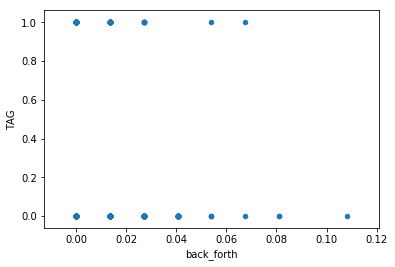

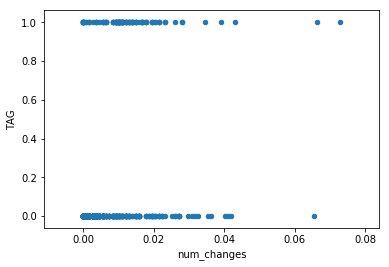

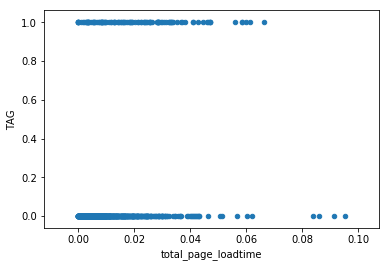

In [23]:
data.plot.scatter(x='back_forth', y='TAG')
data.plot.scatter(x='num_changes', y='TAG')
data.plot.scatter(x='total_page_loadtime', y='TAG')

# Outlier remove
NUM_CHANGES, JS_ERROR contain few outliers that should be removed from the model.

In [25]:
data = data.loc[(data.num_changes < 300) & (data.js_errors < 40)]
data.describe()

,session_ts,page_err,back_forth,total_page_loadtime,num_changes,js_errors,ajax_resp,dwell_time,ajax_errors,CS_Score,TAG
count,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.0,1000.000000,1000.0,1000.000000,1000.000000,1000.000000
mean,1.545697e+12,0.000286,0.004595,1.020279e-02,0.004166,0.0,0.421467,0.0,0.000229,0.440920,0.112000
std,4.271444e+05,0.003540,0.010511,1.194503e-02,0.007629,0.0,0.088274,0.0,0.000536,0.100531,0.315524
min,1.545696e+12,0.000000,0.000000,-3.051860e-07,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.545696e+12,0.000000,0.000000,2.827855e-03,0.000000,0.0,0.372111,0.0,0.000000,0.382336,0.000000
50%,1.545697e+12,0.000000,0.000000,5.716740e-03,0.000934,0.0,0.436472,0.0,0.000000,0.449962,0.000000
75%,1.545697e+12,0.000000,0.000000,1.301077e-02,0.005602,0.0,0.480166,0.0,0.000264,0.503740,0.000000
max,1.545697e+12,0.095238,0.108108,9.519730e-02,0.072829,0.0,0.648800,0.0,0.006997,0.810530,1.000000


# Correlation tests

In [28]:
data.corr(method='pearson')

,session_ts,page_err,back_forth,total_page_loadtime,num_changes,js_errors,ajax_resp,dwell_time,ajax_errors,CS_Score,TAG
session_ts,1.000000,0.054063,0.010506,0.034516,0.045887,NaN,-0.011016,NaN,0.015819,0.000694,0.028399
page_err,0.054063,1.000000,0.085875,0.131229,0.110800,NaN,0.045474,NaN,0.051756,0.108414,0.042453
back_forth,0.010506,0.085875,1.000000,0.406368,0.126145,NaN,0.153105,NaN,0.055955,0.300032,0.015989
total_page_loadtime,0.034516,0.131229,0.406368,1.000000,0.364786,NaN,0.410126,NaN,0.140558,0.554581,0.324008
num_changes,0.045887,0.110800,0.126145,0.364786,1.000000,NaN,0.398989,NaN,0.404101,0.488938,0.400011
js_errors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ajax_resp,-0.011016,0.045474,0.153105,0.410126,0.398989,NaN,1.000000,NaN,0.378017,0.977877,0.205044
dwell_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ajax_errors,0.015819,0.051756,0.055955,0.140558,0.404101,NaN,0.378017,NaN,1.000000,0.392400,0.049090
CS_Score,0.000694,0.108414,0.300032,0.554581,0.488938,NaN,0.977877,NaN,0.392400,1.000000,0.252413


The most correlated features seems to be the number of changes of an element and the focus time.

# Logistic regression

In [23]:
data.columns[:-1]

Index(['SUM_LONG_PAGE_LOAD', 'NUM_CLICKS', 'NUM_CHANGES', 'JS_ERROR', 'LONG_FOCUS_TIME'], dtype='object')

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import time

x_train, x_test, y_train, y_test = train_test_split(data[data.columns[:-1]], data.TAG, test_size=0.33, random_state=42)
#x_train, x_test, y_train, y_test = train_test_split(data['LONG_FOCUS_TIME'], data.TAG, test_size=0.33, random_state=42)
print(time.ctime(), f'Train size:{len(y_train)}, test size:{len(y_test)}')
model = LogisticRegression(fit_intercept=False)
print(time.ctime(), 'Fit...')
#model.fit(x_train.values.reshape(-1, 1), y_train)
model.fit(x_train, y_train)
print("Regression coefficients:")
display(list(zip(model.coef_[0], data.columns[:-1])))
#display(list(zip(model.coef_[0], ['LONG_FOCUS_TIME'])))
print(time.ctime(),' ','Evaluate...')

# Evaluate on test_data of dealtoevaluate
#test_P = model.predict(x_test.values.reshape(-1, 1))
test_P = model.predict(x_test)
print(f'{test_P.sum()} samples out of {len(test_P)} are predicted to complete checkout.')
auc = skm.roc_auc_score(y_test, test_P) # Relevant only for classification tasks like FinalCatP, not for regression (continuous label)
r2 = skm.r2_score(y_test, test_P)
mae = skm.mean_absolute_error(y_test, test_P)
mse = skm.mean_squared_error(y_test, test_P)
print(' R^2: ' + str(r2) + '\n MAE: ' + str(mae) + '\n MSE: ' + str(mse) + '\n AUC: ' + str(auc))


Mon May  7 16:23:44 2018 Train size:234466, test size:115484
Mon May  7 16:23:44 2018 Fit...
Regression coefficients:


[(-0.7828807454636414, 'SUM_LONG_PAGE_LOAD'),
 (-0.030641563105615426, 'NUM_CLICKS'),
 (0.1025774556541286, 'NUM_CHANGES'),
 (0.03358867292550881, 'JS_ERROR'),
 (0.22581330276491962, 'LONG_FOCUS_TIME')]

Mon May  7 16:23:44 2018   Evaluate...
17591 samples out of 115484 are predicted to complete checkout.
 R^2: -0.3774245395563307
 MAE: 0.1913858196806484
 MSE: 0.1913858196806484
 AUC: 0.6383436734071982


# Forward Stepwise Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import time

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            model = LogisticRegression(fit_intercept=False)
            #formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            score = model.fit(data[selected+[candidate]], data[response]).score(data[selected+[candidate]], data[response]) # smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        print(time.ctime(), scores_with_candidates)
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print(time.ctime(), ' ', f'Variable for model: {best_candidate}, score with candidate:{best_new_score}')
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        else:
            break
    #formula = "{} ~ {} + 1".format(response,' + '.join(selected))
    #model = smf.ols(formula, data).fit()
    #return model

forward_selected(data, 'TAG')

Mon May  7 15:32:14 2018 [(0.833981511908674, 'JS_ERROR'), (0.833981511908674, 'NUM_CHANGES'), (0.833981511908674, 'NUM_CLICKS'), (0.833981511908674, 'SUM_LONG_PAGE_LOAD'), (0.8519266762869512, 'LONG_FOCUS_TIME')]
Mon May  7 15:32:14 2018   Variable for model: LONG_FOCUS_TIME, score with candidate:0.8519266762869512
Mon May  7 15:32:15 2018 [(0.8316326384820906, 'SUM_LONG_PAGE_LOAD'), (0.8453515451986684, 'JS_ERROR'), (0.8465402694632167, 'NUM_CHANGES'), (0.8480690374476718, 'NUM_CLICKS')]


# Decision tree

In [38]:
from sklearn import tree
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import time

x_train, x_test, y_train, y_test = train_test_split(data[data.columns[:-1]], data.TAG,  test_size=0.33, random_state=42)
print(time.ctime(), f'Train size:{len(y_train)}, test size:{len(y_test)}')
model = tree.DecisionTreeClassifier()
model.fit(x_train, y_train)

#Evaluate model
y_pred = model.predict(x_test)
print(f'{y_pred.sum()} samples out of {len(y_pred)} are predicted to complete checkout.')
auc = skm.roc_auc_score(y_test,y_pred)
r2 = skm.r2_score(y_test,y_pred)
mae = skm.mean_absolute_error(y_test, y_pred)
mse = skm.mean_squared_error(y_test, y_pred)
print(' R^2: ' + str(r2) + '\n MAE: ' + str(mae) + '\n MSE: ' + str(mse) + '\n AUC: ' + str(auc))

Mon May  7 16:24:30 2018 Train size:234466, test size:115484
16657 samples out of 115484 are predicted to complete checkout.
 R^2: -0.008981236784770363
 MAE: 0.14019258079041252
 MSE: 0.14019258079041252
 AUC: 0.7207555921065266


In [ ]:
#Display the tree
import graphviz

dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=data.columns[:-1],  
                         class_names=['0', '1'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render('tree-output.gv')
#graph
#Image(graph.create_png())
#dot -Tpng tree-output-2.gv -o tree-output-2.png